# Offline Phase: GEIM algorithm

This notebook implements the offline phase of the following algorithms:

- Generalised Empirical Interpolation Method (GEIM)

In particular, the magic functions and magic sensors are generated through the GEIM procedure, **for the observable field only** ($T$ in this case).

The current version of the *pyforce* package allows for GEIM only scalar fields.

In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm

from mpi4py import MPI
from dolfinx.io import gmshio
import gmsh
from dolfinx.fem import Function, FunctionSpace
import ufl

from pyforce.offline.geim import GEIM
from pyforce.tools.functions_list import FunctionsList
from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store

path = './Snapshots/'
path_offline = './Offline_results/'
if not os.path.exists(path_offline):
    os.makedirs(path_offline)

# The temperature is the only one that can be measured
var_names = ['norm_T']
tex_var_names = ['T']

Let us generate the mesh for importing OpenFOAM dataset into *dolfinx*

In [2]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cavity.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Import into dolfinx
model_rank = 0
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )
gmsh.finalize()

########################################################################################################

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

Info    : Reading 'cavity.geo'...
Info    : Done reading 'cavity.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000561164s, CPU 0.000411s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00840923s, CPU 0.008269s)
Info    : 16384 nodes 32770 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 2.59234e-06s, CPU 7e-06s)


Let us define the functional space onto which the OpenFOAM data have been projected; then, the snapshots can be imported.

In [3]:
fun_spaces = [FunctionSpace(domain, ('Lagrange', 1))]

train_snaps = dict()
test_snaps  = dict()

training = True

for field_i, field in enumerate(var_names):
    
    if training:
        path_snap = path+'TrainSet_'+field
    else:
        path_snap = path+'TestSet_' +field
    tmp = ImportH5(fun_spaces[field_i], path_snap, field)
    
    if training:
        train_snaps[field] = tmp[0]
    else:
        test_snaps[field] = tmp[0]

## GEIM algorithm

### Generation of the magic functions/sensors
The GEIM is used to generated through a greedy process a set of basis functions and basis sensors for the data assimilation process.

Sensors are mathematically modelled as linear continuous functionals $v_m(\cdot)$, defined as
\begin{equation*}
v_m(u(\mathbf{x});\,\mathbf{x}_m,\,s)=\int_\Omega u(\mathbf{x})\cdot \mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\,d\Omega
\end{equation*}
given $\mathbf{x}_m$ the centre of mass of the functional and $s$ its point spread. The current version adopts Gaussian kernels 
\begin{equation*}
\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right) = \frac{e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}}{\displaystyle\int_\Omega e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}\,d\Omega}
\end{equation*}
such that $\|\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\|_{L^1(\Omega)}=1$, this models the measurement process of scalar fields.

In [4]:
geim_data = dict()
train_GEIMcoeff = dict()
Mmax = 30

# This parameter serves as input to select only some cells in the mesh
sam_every = 2

s = 0.01

train_abs_err = np.zeros((Mmax, len(var_names)))
train_rel_err = np.zeros((Mmax, len(var_names)))

for field_i, field in enumerate(var_names):
    geim_data[field] = GEIM(domain, fun_spaces[field_i], field_i, s=s)
    tmp = geim_data[field].offline(train_snaps[field], Mmax, sampleEvery = sam_every, verbose = True)

    train_abs_err[:, field_i] = tmp[0].flatten()
    train_rel_err[:, field_i] = tmp[1].flatten()
    train_GEIMcoeff[field] = tmp[2]

Generating sensors (sampled every 2 cells): 8192.000 / 8192.00 - 0.005 s/it


Let us store the magic functions and the magic sensors

In [6]:
if not os.path.exists(path_offline+'/BasisSensors/'):
    os.makedirs(path_offline+'/BasisSensors/')
if not os.path.exists(path_offline+'/BasisFunctions/'):
    os.makedirs(path_offline+'/BasisFunctions/')

pickle.dump(train_GEIMcoeff, open(path_offline+'coeffs.geim', 'wb'))

for field in var_names:    
    store(domain, geim_data[field].magic_fun,  'GEIM_' +field, path_offline+'/BasisFunctions/basisGEIM_' + field)
    store(domain, geim_data[field].magic_sens, 'GEIM_' +field, path_offline+'/BasisSensors/sensorsGEIM_' + field)

### Post-process: plotting magic functions and sensors
The magic functions and sensors are plotted using `pyvista`.

In [7]:
import vtk
import pyvista as pv
import dolfinx

pv.start_xvfb()

def grids(fun: dolfinx.fem.Function):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    u_grid.point_data['fun'] = fun.x.array[:].real
    u_grid.set_active_scalars('fun')
    return u_grid

The first 6 magic functions are plotted.

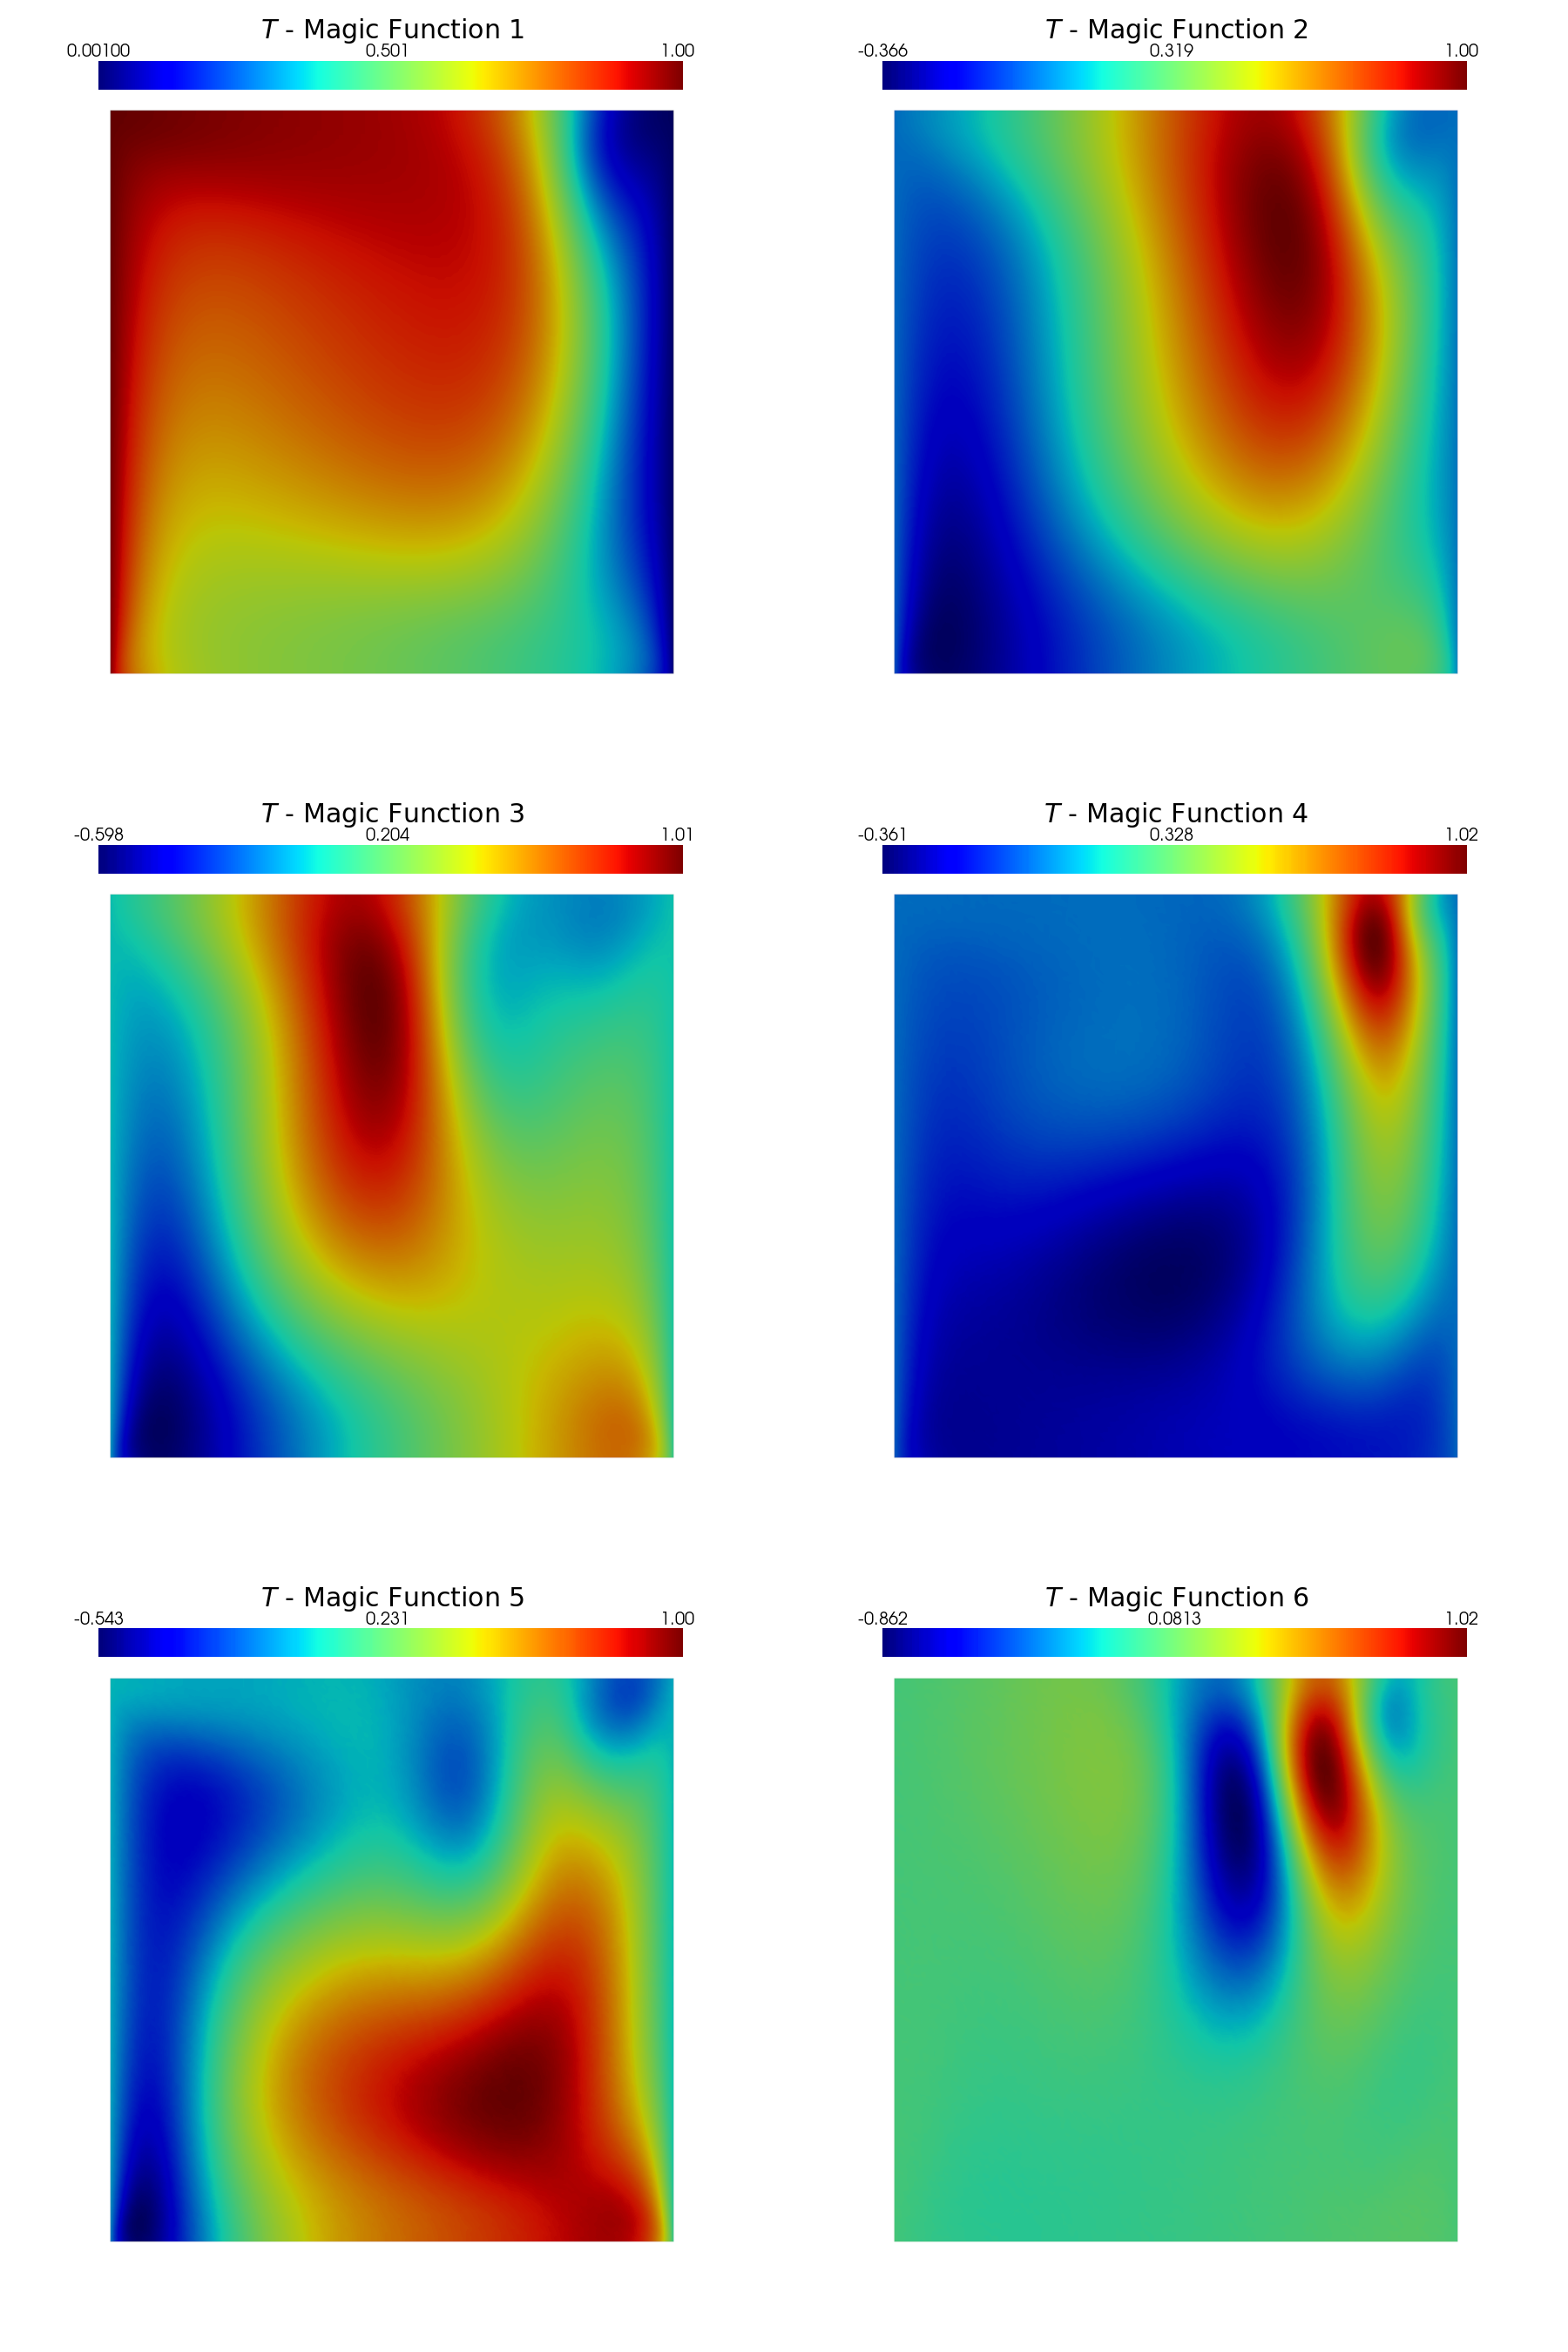

In [14]:
def plotBasisFun( basis: FunctionsList, varname: str, shape : list,
               colormap = cm.jet):  
    
    nrows = shape[0]
    ncols = shape[1]
    
    resolution = [900 * ncols, 900 * nrows]
    plotter = pv.Plotter(shape=shape, off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 20
    title_fontsize = 30
    zoom = 1.05
    
    dict_cb = dict(title = varname, width = 0.75, height = 0.1,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=3,
                    color = 'k',
                    position_x=0.125, position_y=0.885,
                    shadow=False) 
    
    idx = 0
    for row in range(nrows):
        for col in range(ncols):
            warped = grids(basis.map(idx))
            clim = [min(basis(idx)), max(basis(idx))]
                
            plotter.subplot(row, col)
            dict_cb['title'] = '$'+varname+'$'+' - Magic Function '+str(idx+1)
            plotter.add_mesh(warped, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
            plotter.view_xy()
            plotter.camera.zoom(zoom)
            
            idx += 1

    plotter.set_background('white', top='white')
    plotter.show()
    
plotBasisFun(geim_data['norm_T'].magic_fun, tex_var_names[0], (3,2))

Then, let us plot the magic sensors.

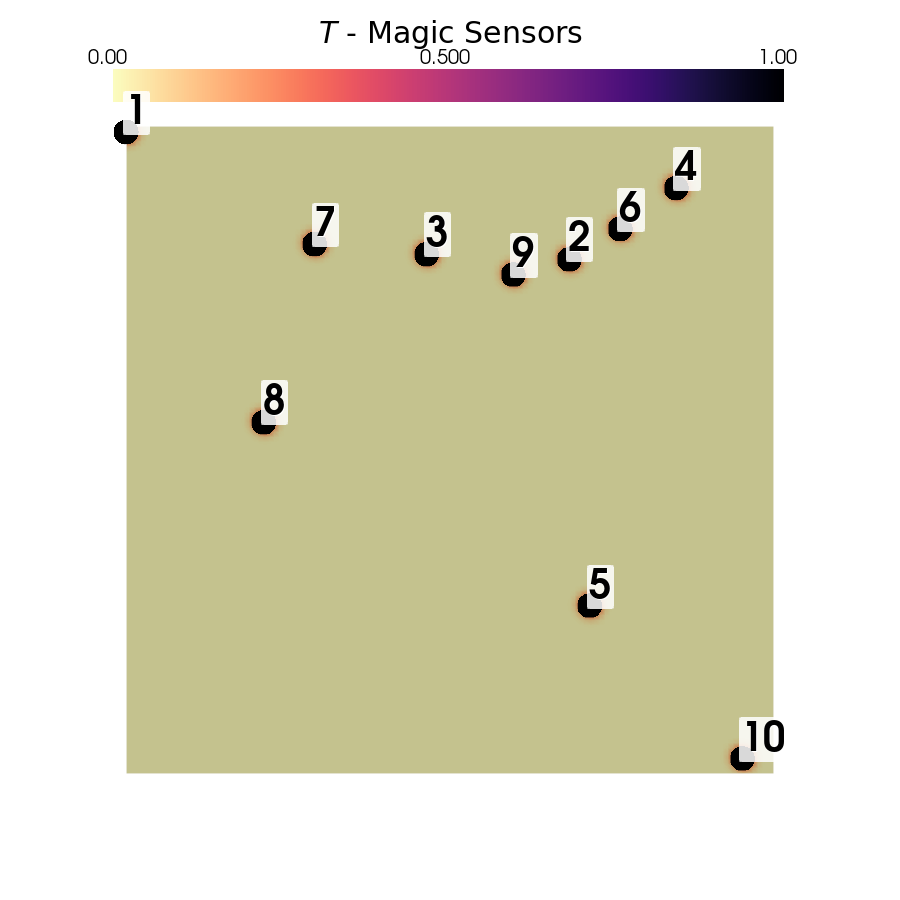

In [29]:
def sens_pos(sens: FunctionsList, domain, M):
    x_dofs = domain.geometry.x
    
    x_sens = list()
    for mm in range(M):
        x_sens.append(x_dofs[np.argmax(sens(mm))])
    return np.asarray(x_sens)

def plotBasisSens( basis: FunctionsList, varname: str, M_to_use: int,
                   colormap = cm.magma_r):  
    
    resolution = [900, 900]
    plotter = pv.Plotter(off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 20
    title_fontsize = 30
    zoom = 1.05
    
    dict_cb = dict(title = varname, width = 0.75, height = 0.1,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=3,
                    color = 'k',
                    position_x=0.125, position_y=0.885,
                    shadow=False) 
    
    sensors = Function(basis.fun_space)
    sensors.x.array[:] = sum([basis(idx) / max(basis(idx)) for idx in range(M_to_use)])
    
    dict_cb['title'] = '$'+varname+'$'+' - Magic Sensors'
    warped = grids(sensors)
    plotter.add_mesh(warped, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
            
    _sens = sens_pos(basis, domain, M_to_use)
    plotter.add_point_labels(_sens, np.arange(1, M_to_use+1,1), italic=False,
                        font_size=40,
                        point_color='black',
                        shape_color='white',
                        shape_opacity=0.85,
                        point_size=25,
                        render_points_as_spheres=True,
                        always_visible=True,
                        shadow=True)
    
    plotter.view_xy()
    plotter.camera.zoom(zoom)
            
    plotter.set_background('white', top='white')
    plotter.show()
    
    return sensors
    
aa = plotBasisSens(geim_data['norm_T'].magic_sens, tex_var_names[0], 10)